In [1]:
""""
Experiment to check how a Support Vector Machine model reacts against
modifications in the synthetic testing datasets.
"""

import torch
from data import load_csv_to_df
import metrics
from graph import get_flow_features_values, get_encoded_label
from data import modify_portscan_attack_behavior,train_test_split_stratify,export_to_csv
import configparser
from sklearn import svm
import os

source_code_dir = '/home/dev/src'

print(os.getcwd())

config = configparser.ConfigParser()
config.read(source_code_dir+"/config.ini")


model = svm.SVC()


data = load_csv_to_df(
    config["PARAMETERS"]["DataFolderPath"] + config["PARAMETERS"]["TrainFile"])

# test = load_csv_to_df(
#     config["PARAMETERS"]["DataFolderPath"] + config["PARAMETERS"]["EvalFile"])

# 데이터 셋 분리 
train,test  = train_test_split_stratify(data,0.3)

print('train_data label rate',train[' Label'].value_counts())
print()
print('test_data label rate',test[' Label'].value_counts())



/home/dev/src
train_data label rate  Label
PortScan    127144
BENIGN      102029
Name: count, dtype: int64

test_data label rate  Label
PortScan    31786
BENIGN      25508
Name: count, dtype: int64


In [2]:
labels_map = {"BENIGN": 0, "PortScan": 1}
labels = ["BENIGN", "PortScan"]

flow_features = [" Flow Duration"]

# flow_features = [
#     " Average Packet Size",
#     " Flow IAT Mean",
#     " Flow Duration",
# ]

flow_features = [    
    " Flow Duration",
    " Flow Packets/s",
    " Flow IAT Mean",
    " Fwd IAT Mean",
    " Bwd IAT Mean",]



In [3]:
# synthetic noise를 위한 영역
# test = modify_portscan_attack_behavior(test)

# train vectors
x_train = []
y_train = []

for _, row in train.iterrows():
    x_train.append(get_flow_features_values(row, flow_features))
    y_train.append(get_encoded_label(
        row, labels_map))

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

# test vectors
x_test = []
y_test = []
for _, row in test.iterrows():
    x_test.append(get_flow_features_values(row, flow_features))
    y_test.append(get_encoded_label(
        row, labels_map))


In [4]:
x_train.shape, y_train.shape

(torch.Size([229173, 5]), torch.Size([229173]))

In [5]:

x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

print("Training model...")
model.fit(x_train, y_train)
print("Evaluating model...")

print(model.score(x_test, y_test))


Training model...
Evaluating model...
0.6900897127098824


In [18]:
pred = model.predict(x_test)
metrics.compute_metrics(y_test, pred)

{'F1 Score': 0.6249329914533137,
 'Accuracy': 0.6900897127098824,
 'Recall': 0.6522504340197053,
 'Precision': 0.8161495567368675}

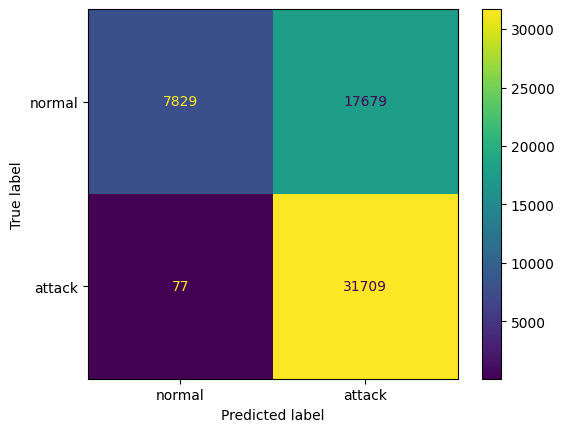

In [27]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred)
labels = ['normal','attack']
cm_display  = ConfusionMatrixDisplay(confusion_matrix=conf_mat, 
                                     display_labels  = labels,
                                     
                                     )
cm_display.plot()
plt.show()

